# First Cell: Install Required Libraries

In [1]:
!pip install transformers datasets evaluate matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

# Cell 2: Load the IMDB Dataset

In [2]:
from datasets import load_dataset

# Load IMDB dataset
dataset = load_dataset("imdb")

# Show dataset structure
print(dataset)


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


# Cell 3: Tokenize the text reviews

In [3]:
from transformers import AutoTokenizer

# Load RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Keep only necessary columns
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

print(tokenized_datasets)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})


# Cell 4: Prepare the data loaders and load the RoBERTa model

In [4]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# Load RoBERTa model for binary classification (positive vs negative)
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Define training arguments (compatible with older versions of transformers)
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    eval_strategy="steps",
    eval_steps=100,
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_strategy="epoch",   # keep only supported args
    report_to="none", 
)

print("Model and training arguments are ready.")


2025-08-26 09:51:59.528724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756201919.768154      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756201919.837625      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and training arguments are ready.


# Cell 5: Define the evaluation metrics function

In [5]:
import evaluate
import numpy as np

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Define function for computing metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"],
    }

print("Metrics function is ready.")


Metrics function is ready.


# Cell 6: Set up the Trainer

In [6]:
from torch.utils.data import DataLoader

# Split dataset into train and test
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("Trainer is ready.")


Trainer is ready.


# Cell 7: Training RoBERTa

In [7]:
from transformers import TrainerCallback
from tqdm import tqdm
import time

# Custom callback to show tqdm progress and metrics
class TQDMProgressCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()
        self.epoch_bar = tqdm(total=len(train_dataset)//args.per_device_train_batch_size, 
                              desc=f"Epoch {int(state.epoch)+1}", leave=True)

    def on_step_end(self, args, state, control, **kwargs):
        self.epoch_bar.update(1)

    def on_epoch_end(self, args, state, control, **kwargs):
        self.epoch_bar.close()
        elapsed = time.time() - self.epoch_start_time
        print(f"Epoch {int(state.epoch)+1} completed in {elapsed:.2f} seconds")
        # Print last logged metrics if available
        if state.log_history:
            logs = state.log_history[-1]
            if "loss" in logs:
                print(f"Train Loss: {logs['loss']:.4f}")
            if "eval_accuracy" in logs:
                print(f"Validation Accuracy: {logs['eval_accuracy']:.4f}")

# Add the callback
trainer.add_callback(TQDMProgressCallback)

# Start training with time tracking
start_time = time.time()
train_result = trainer.train()
end_time = time.time()

# Save fine-tuned model
trainer.save_model("./roberta-imdb-finetuned")

# Save training metrics
metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

print(f"Training complete in {(end_time - start_time)/60:.2f} minutes")


Epoch 1:   0%|          | 0/3125 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.566100,0.442757,0.880920,0.886783,0.880920,0.880467
200,0.391300,0.253689,0.909000,0.910182,0.909000,0.908934
300,0.348900,0.408258,0.900080,0.906262,0.900080,0.899698
400,0.355800,0.284808,0.915760,0.916739,0.915760,0.915710
500,0.367100,0.381108,0.880640,0.894537,0.880640,0.879580
600,0.374100,0.313671,0.909760,0.912031,0.909760,0.909635
700,0.334900,0.305943,0.920880,0.920893,0.920880,0.920879
800,0.266300,0.391949,0.913680,0.915183,0.913680,0.913602
900,0.320900,0.302993,0.919200,0.919955,0.919200,0.919164
1000,0.338600,0.301987,0.921720,0.922351,0.921720,0.921691


Epoch 1: 100%|██████████| 3125/3125 [1:44:55<00:00,  2.01s/it]


Epoch 2 completed in 6295.94 seconds
Validation Accuracy: 0.9350


Epoch 2: 100%|██████████| 3125/3125 [1:44:38<00:00,  2.01s/it]


Epoch 3 completed in 6278.78 seconds
Validation Accuracy: 0.9379
***** train metrics *****
  epoch                    =        2.0
  total_flos               =  6126031GF
  train_loss               =     0.2517
  train_runtime            = 3:29:39.94
  train_samples_per_second =      3.975
  train_steps_per_second   =      0.497
Training complete in 209.67 minutes


# Cell 8: Visualize Results

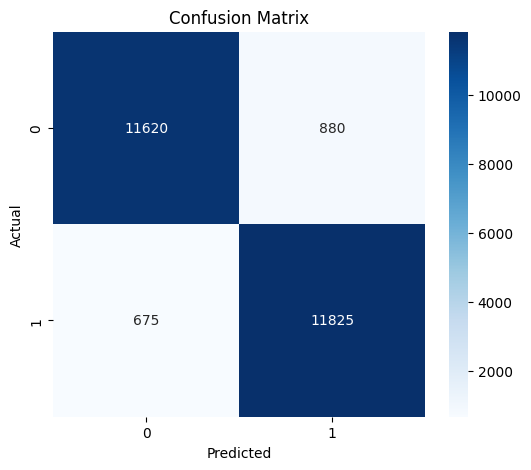

Classification Report:

              precision    recall  f1-score   support

    negative       0.95      0.93      0.94     12500
    positive       0.93      0.95      0.94     12500

    accuracy                           0.94     25000
   macro avg       0.94      0.94      0.94     25000
weighted avg       0.94      0.94      0.94     25000



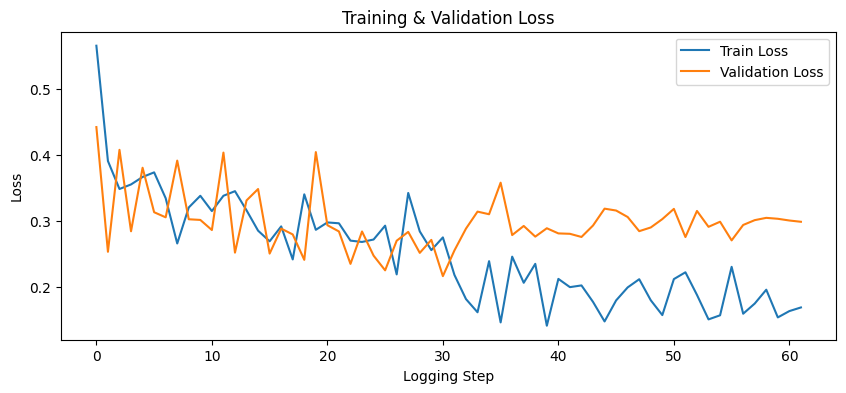

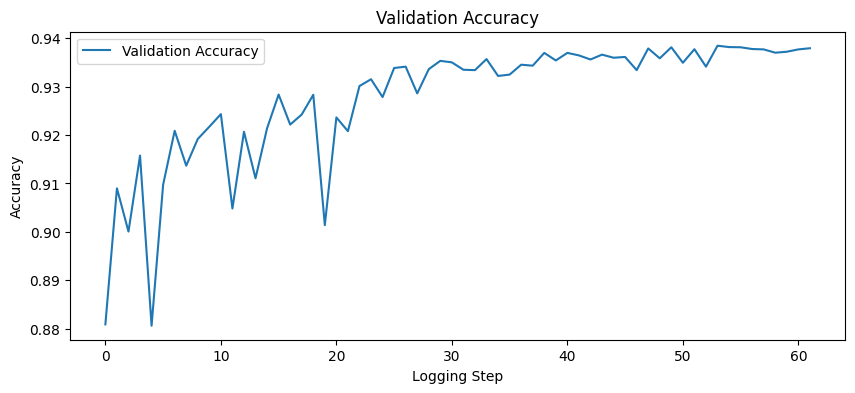

In [8]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Create DataLoader for test set
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=16)

all_preds = []
all_labels = []

# Generate predictions
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(trainer.args.device)
        attention_mask = batch["attention_mask"].to(trainer.args.device)
        labels = batch["labels"].to(trainer.args.device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=["negative","positive"])
print("Classification Report:\n")
print(report)

# Plot Training & Validation Loss Curve
logs = trainer.state.log_history

train_loss = [x["loss"] for x in logs if "loss" in x]
eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]
eval_accuracy = [x["eval_accuracy"] for x in logs if "eval_accuracy" in x]

plt.figure(figsize=(10,4))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Plot Validation Accuracy Curve
plt.figure(figsize=(10,4))
plt.plot(eval_accuracy, label="Validation Accuracy")
plt.xlabel("Logging Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()


# Cell 9: Saving the model

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Path to save the model
save_path = "./roberta-imdb-finetuned"

# Save the fine-tuned model
trainer.model.save_pretrained(save_path)

# Save the tokenizer as well
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved to {save_path}")


Model and tokenizer saved to ./roberta-imdb-finetuned
